# Naive Bayes Spam Classifier

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

## 1. Load and Prepare Data

In [4]:
df = pd.read_csv('data/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (5572, 2)

First few rows:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 2. Split Data into Training and Testing Sets

Split the data into 70% training and 30% testing. The `stratify` parameter ensures both sets have the same spam/ham ratio, which is crucial for imbalanced datasets.

In [5]:
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df['label']
)

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTraining distribution:\n{train_df['label'].value_counts()}")
print(f"\nTest distribution:\n{test_df['label'].value_counts()}")

Training samples: 3900
Test samples: 1672

Training distribution:
label
ham     3377
spam     523
Name: count, dtype: int64

Test distribution:
label
ham     1448
spam     224
Name: count, dtype: int64


## 3. Text Vectorization

`CountVectorizer` converts text documents into a matrix of token counts. It handles:
- **Tokenization**: Splitting sentences into words
- **Lowercasing**: Normalizing case
- **Stop words**: Removing common words (optional)

We'll fit it on the training data only to avoid data leakage, then transform both spam and ham separately.

In [6]:
# Initialize vectorizer (removes common English stop words)
vectorizer = CountVectorizer(stop_words='english')

# Fit on all training data and transform
X_train_counts = vectorizer.fit_transform(train_df['message'])

# Get feature names (unique words)
feature_names = vectorizer.get_feature_names_out()
print(f"Vocabulary size: {len(feature_names)}")
print(f"Sample features: {feature_names[:100]}")

# Separate spam and ham matrices
spam_matrix = vectorizer.transform(train_df[train_df['label'] == 'spam']['message'])
ham_matrix = vectorizer.transform(train_df[train_df['label'] == 'ham']['message'])

Vocabulary size: 6860
Sample features: ['00' '000' '000pes' '008704050406' '0089' '0121' '01223585334' '02'
 '0207' '02072069400' '02073162414' '02085076972' '021' '03' '04' '0430'
 '05' '050703' '0578' '06' '07' '07008009200' '07046744435' '07099833605'
 '07123456789' '0721072' '07734396839' '07742676969' '07753741225'
 '07781482378' '07786200117' '078' '07801543489' '07808' '07808247860'
 '07808726822' '07815296484' '07821230901' '078498' '0789xxxxxxx'
 '0796xxxxxx' '07xxxxxxxxx' '0800' '08000407165' '08000839402'
 '08000930705' '08000938767' '08001950382' '08002888812' '08002986030'
 '08002986906' '08002988890' '08006344447' '0808' '08081263000'
 '08081560665' '0825' '083' '0844' '08448350055' '08448714184' '0845'
 '08450542832' '08452810073' '08452810075over18' '0870' '08700469649'
 '08700621170150p' '08701213186' '08701417012' '08701417012150p'
 '0870141701216' '087018728737' '0870241182716' '08702840625'
 '08706091795' '0870737910216yrs' '08707509020' '0870753331018'
 '0870780822

## 4. Calculate Class Priors

The prior probability is simply the proportion of each class in the training data.

In [7]:
# Calculate prior probabilities
p_spam = len(train_df[train_df['label'] == 'spam']) / len(train_df)
p_ham = len(train_df[train_df['label'] == 'ham']) / len(train_df)

print(f"P(Spam) = {p_spam:.4f}")
print(f"P(Ham)  = {p_ham:.4f}")

P(Spam) = 0.1341
P(Ham)  = 0.8659


## 5. Calculate Word Conditional Probabilities

For each word, we calculate:
- **Spamicity**: Probability word appears in a spam email
- **Hamicity**: Probability word appears in a ham email

We use **Laplace smoothing** (add-1 smoothing) to handle unseen words and avoid zero probabilities:
```
P(word|Spam) = (spam_emails_with_word + 1) / (total_spam_emails + 2)
```

We count **documents** containing each word, not raw frequency, following the Bernoulli Naive Bayes model.

In [33]:
# Initialize probability dictionaries
spamicity = {}
hamicity = {}
word_count = {
    'word': [],
    'spam': [],
    'ham': [],
}

# Calculate for each word in vocabulary
for idx, word in enumerate(feature_names):
    # Count documents containing the word
    spam_docs_with_word = (spam_matrix[:, idx].toarray() > 0).sum()
    ham_docs_with_word = (ham_matrix[:, idx].toarray() > 0).sum()
    # Apply Laplace smoothing
    spamicity[word] = (spam_docs_with_word + 1) / (spam_matrix.shape[0] + 2)
    hamicity[word] = (ham_docs_with_word + 1) / (ham_matrix.shape[0] + 2)
    ## :TODO
    #if word == 'free' or word == 'just' or word == 'urgent':
    #    print(word)
    #    print(spam_docs_with_word)
    #    print(ham_docs_with_word)
    #    print(spam_docs_with_word + ham_docs_with_word)
    #word_count[word] = {'spam': spam_docs_with_word, 'ham': ham_docs_with_word}
    word_count['word'].append(word)
    word_count['spam'].append(spam_docs_with_word)
    word_count['ham'].append(ham_docs_with_word)
print("Sample probabilities:")
for word in ['just', 'website', 'free', 'hi'][:4]:
    print(f"'{word}': Spamicity={spamicity[word]:.4f}, Hamicity={hamicity[word]:.4f}")

#word_count['just']

Sample probabilities:
'just': Spamicity=0.0990, Hamicity=0.0574
'website': Spamicity=0.0038, Hamicity=0.0015
'free': Spamicity=0.2305, Hamicity=0.0118
'hi': Spamicity=0.0248, Hamicity=0.0228


In [48]:
word_count_df = pd.DataFrame(word_count)
word_count_df.nlargest(n = 10,columns=['ham'])
word_count_df.nlargest(n = 10,columns=['spam'])

,word,spam,ham
2698,free,120,39
6291,txt,112,12
6390,ur,81,136
6036,text,78,48
1654,claim,75,0
5781,stop,74,24
6768,www,73,2
4073,mobile,70,13
5094,reply,69,27
3477,just,51,193


[Text(0.5, 1.0, 'Top 10 Ham Words'), Text(0.5, 0, 'count')]

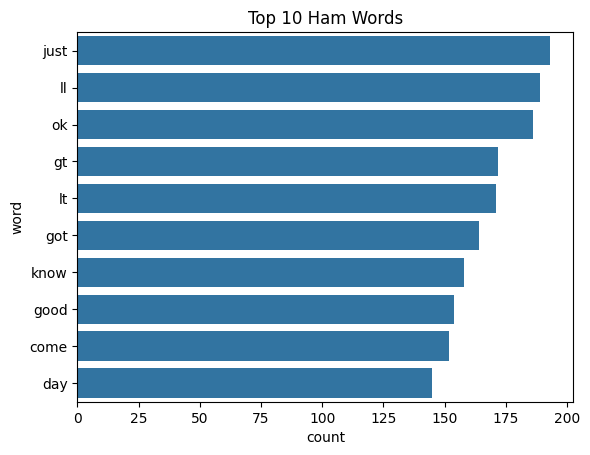

In [53]:
sns.barplot(data=word_count_df.nlargest(n = 10,columns=['ham']), x='ham', y='word').set(title="Top 10 Ham Words", xlabel='count')

[Text(0.5, 1.0, 'Top 10 Spam Words'), Text(0.5, 0, 'count')]

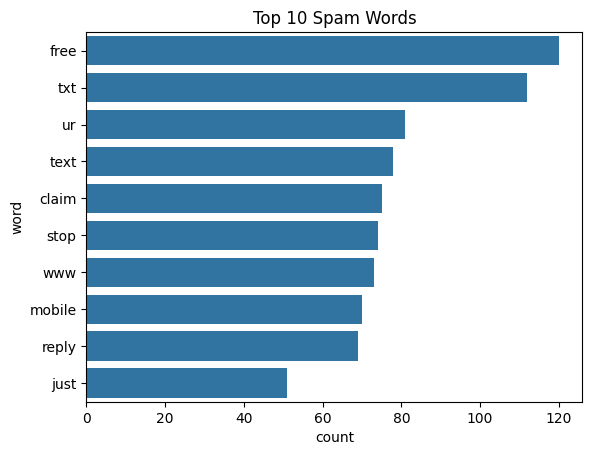

In [52]:
sns.barplot(data=word_count_df.nlargest(n = 10,columns=['spam']), x='spam', y='word').set(title="Top 10 Spam Words",xlabel="count")

In [19]:
vectorizer.vocabulary_

{'goal': 2859,
 'arsenal': 986,
 'henry': 3075,
 'liverpool': 3735,
 'scores': 5301,
 'simple': 5496,
 'shot': 5456,
 'yards': 6798,
 'pass': 4539,
 'bergkamp': 1210,
 'margin': 3912,
 '78': 581,
 'mins': 4031,
 'said': 5243,
 'gonna': 2878,
 'snow': 5599,
 'start': 5744,
 'pm': 4685,
 'tonite': 6184,
 'predicting': 4787,
 'inch': 3280,
 'accumulation': 738,
 'aah': 696,
 'bless': 1262,
 'arm': 975,
 'oh': 4389,
 'come': 1732,
 'tomorrow': 6176,
 'happening': 3007,
 'gotten': 2899,
 'job': 3437,
 'begun': 1192,
 'registration': 5049,
 'permanent': 4590,
 'residency': 5108,
 'quite': 4928,
 'ok': 4394,
 'bit': 1244,
 'ex': 2432,
 'better': 1215,
 'eat': 2281,
 'smth': 5591,
 'll': 3739,
 'feel': 2541,
 'guilty': 2964,
 'want': 6543,
 'new': 4262,
 'video': 6458,
 'phone': 4618,
 '600': 532,
 'anytime': 921,
 'network': 4256,
 '400': 443,
 'inclusive': 3286,
 'calls': 1476,
 'downloads': 2205,
 'week': 6596,
 'free': 2698,
 'deltomorrow': 2032,
 '08002888812': 48,
 'reply': 5094,
 'dont'

## 6. Prediction Function

Our `predict()` function:
1. Vectorizes the input email
2. Calculates **log probabilities** to prevent numerical underflow
3. Multiplies probabilities (adds logs) for all words
4. Normalizes to get final spam confidence
5. Returns classification and probability

In [9]:
def predict(email):
    """
    Predict whether an email is spam or ham using manual Naive Bayes
    Returns: (prediction, spam_probability)
    """
    # Vectorize the email
    email_vector = vectorizer.transform([email])
    words_in_email = [feature_names[i] for i in email_vector.indices]
    
    # Start with log priors
    log_prob_spam = np.log(p_spam)
    log_prob_ham = np.log(p_ham)
    
    # Add log conditional probabilities for each word
    for word in words_in_email:
        # Get spamicity/hamicity with smoothing for unseen words
        word_spamicity = spamicity.get(word, 1/(spam_matrix.shape[0] + 2))
        word_hamicity = hamicity.get(word, 1/(ham_matrix.shape[0] + 2))
        
        log_prob_spam += np.log(word_spamicity)
        log_prob_ham += np.log(word_hamicity)
    
    # Convert from log space and normalize
    prob_spam = np.exp(log_prob_spam)
    prob_ham = np.exp(log_prob_ham)
    total = prob_spam + prob_ham
    
    spam_confidence = prob_spam / total if total > 0 else 0.5
    
    return 'spam' if spam_confidence >= 0.5 else 'ham', spam_confidence

## 7. Custom Evaluation Metrics

We'll implement our own evaluation function to calculate:
- **Accuracy**: Overall correctness
- **Confusion Matrix**: TP, TN, FP, FN
- **Precision**: True spam / Predicted spam
- **Recall**: True spam / Actual spam
- **F1-Score**: Harmonic mean of precision and recall

In [10]:
def evaluate(y_true, y_pred):
    """
    Calculate classification metrics manually
    """
    # Confusion matrix components
    tp = sum(1 for t, p in zip(y_true, y_pred) if t == 'spam' and p == 'spam')
    tn = sum(1 for t, p in zip(y_true, y_pred) if t == 'ham' and p == 'ham')
    fp = sum(1 for t, p in zip(y_true, y_pred) if t == 'ham' and p == 'spam')
    fn = sum(1 for t, p in zip(y_true, y_pred) if t == 'spam' and p == 'ham')
    
    # Accuracy
    accuracy = (tp + tn) / len(y_true) if len(y_true) > 0 else 0
    
    # Spam metrics
    precision_spam = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_spam = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_spam = (2 * precision_spam * recall_spam / (precision_spam + recall_spam) 
               if (precision_spam + recall_spam) > 0 else 0)
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"                Pred Spam  Pred Ham")
    print(f"Actual Spam     {tp:<10} {fn:<10}")
    print(f"Actual Ham      {fp:<10} {tn:<10}")
    print(f"\nSpam Metrics:")
    print(f"  Precision: {precision_spam:.4f}")
    print(f"  Recall:    {recall_spam:.4f}")
    print(f"  F1-Score:  {f1_spam:.4f}")
    
    return {
        'accuracy': accuracy,
        'confusion': {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn},
        'precision': precision_spam,
        'recall': recall_spam,
        'f1': f1_spam
    }

In [ ]:
# Predict on test set
test_predictions = []
test_probabilities = []

for email in test_df['message']:
    pred, prob = predict(email)
    test_predictions.append(pred)
    test_probabilities.append(prob)

# Evaluate results
print("=== Test Set Evaluation ===")
metrics = evaluate(test_df['label'], test_predictions)

=== Test Set Evaluation ===
Accuracy: 0.8385

Confusion Matrix:
                Pred Spam  Pred Ham
Actual Spam     222        2         
Actual Ham      268        1180      

Spam Metrics:
  Precision: 0.4531
  Recall:    0.9911
  F1-Score:  0.6218


<Axes: >

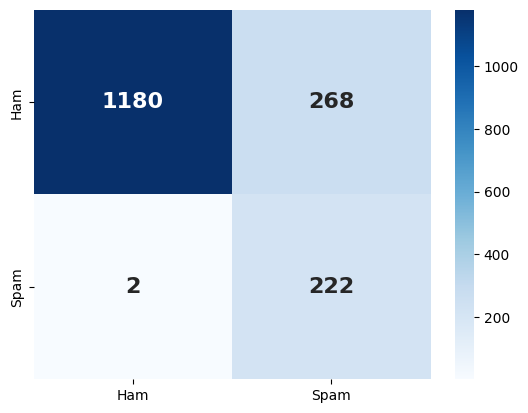

In [55]:
tp = metrics['confusion']['tp']
tn = metrics['confusion']['tn']
fp = metrics['confusion']['fp']
fn = metrics['confusion']['fn']

cm = np.array([[tn, fp],
               [fn, tp]])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'],
            annot_kws={'size': 16, 'weight': 'bold'})


<Axes: >

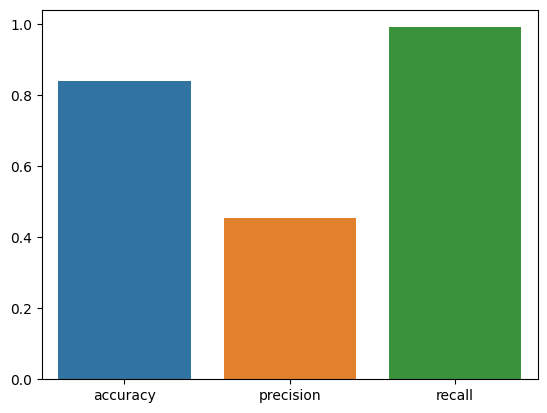

In [61]:
sns.barplot(data=pd.DataFrame(metrics).drop(columns=['confusion','f1'], axis=0))

## 8. Test on Custom Emails

Let's test our classifier on the same emails from your original example to see how it performs.

In [12]:
# Your test emails
custom_emails = [
    'renew your password',
    'renew your vows',
    'benefits of our account',
    'the importance of physical activity'
]

print("=== Custom Email Predictions ===")
for email in custom_emails:
    pred, prob = predict(email)
    print(f"\nEmail: '{email}'")
    print(f"  Prediction: {pred.upper()}")
    print(f"  Spam Confidence: {prob:.4f} ({prob*100:.2f}%)")

=== Custom Email Predictions ===

Email: 'renew your password'
  Prediction: SPAM
  Spam Confidence: 0.5706 (57.06%)

Email: 'renew your vows'
  Prediction: HAM
  Spam Confidence: 0.1341 (13.41%)

Email: 'benefits of our account'
  Prediction: SPAM
  Spam Confidence: 0.9112 (91.12%)

Email: 'the importance of physical activity'
  Prediction: HAM
  Spam Confidence: 0.1341 (13.41%)


In [13]:
# :TODO Make this code sample simpler and add the formulas on top